# Predicting Tax Valuation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

import os
import env, acquire, prepare, features

## Visualizing Tax Rate Distribution
We begin by using our `acquire_cache_tax_data()` function to create a dataframe consisting of the tax rate for every record of interest. We are limiting our records to only those that meet the following requirements:
- Transaction Date between 2017-05-01 and 2017-06-30
- Property classified as one of the following Types:
    - Single Family Residential
    - Rural Residence
    - Mobile Home
    - Townhouse
    - Condominium
    - Row House
    - Bungalow
    - Manufactured, Modular, Prefabricated Homes
    - Patio Home
    - Inferred Single Family Residence

Tax rate is determined by the following formula:

    Tax Paid / Tax Value * 100 (rounded to 2 digits)

In [2]:
tax = acquire.acquire_cache_tax_data()

In [3]:
tax.head()

,taxrate,County
0,1.70,Los Angeles
1,1.53,Los Angeles
2,1.12,Orange
3,1.25,Los Angeles
4,1.19,Los Angeles


We split the dataframe into smaller ones representing each county

In [4]:
los_angeles_taxrate = tax[tax.County == 'Los Angeles'].taxrate
orange_taxrate = tax[tax.County == 'Orange'].taxrate
ventura_taxrate = tax[tax.County == 'Ventura'].taxrate

An initial histogram shows the following:
- The majority of the records are in Los Angeles county
- There is significant positive skew present in at least one of the counties, demonstrated by the large x-axis range
- The majority of the tax rates fall below 5%

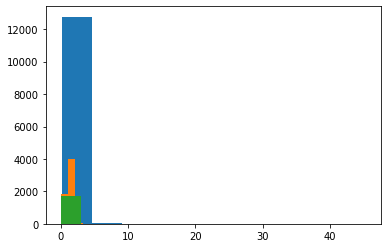

In [5]:
plt.hist(los_angeles_taxrate)
plt.hist(orange_taxrate)
plt.hist(ventura_taxrate)
plt.show()

Descriptive statistics of each county support our visual analysis. 

In [15]:
print(los_angeles_taxrate.describe())
print('\n')
print(orange_taxrate.describe())
print('\n')
print(ventura_taxrate.describe())

count    12807.000000
mean         1.380155
std          0.672991
min          0.110000
25%          1.210000
50%          1.250000
75%          1.390000
max         45.290000
Name: taxrate, dtype: float64


count    5845.000000
mean        1.205100
std         0.292402
min         0.010000
25%         1.050000
50%         1.150000
75%         1.260000
max        10.740000
Name: taxrate, dtype: float64


count    1711.000000
mean        1.212215
std         0.743119
min         0.080000
25%         1.070000
50%         1.120000
75%         1.190000
max        29.490000
Name: taxrate, dtype: float64


We create more meaningful visualizations of the distribution in each county
- Increase the number of bins
- Trim the x-axis to focus only on the region with the vast majority of observations
- Visualizing the mean and median for each region

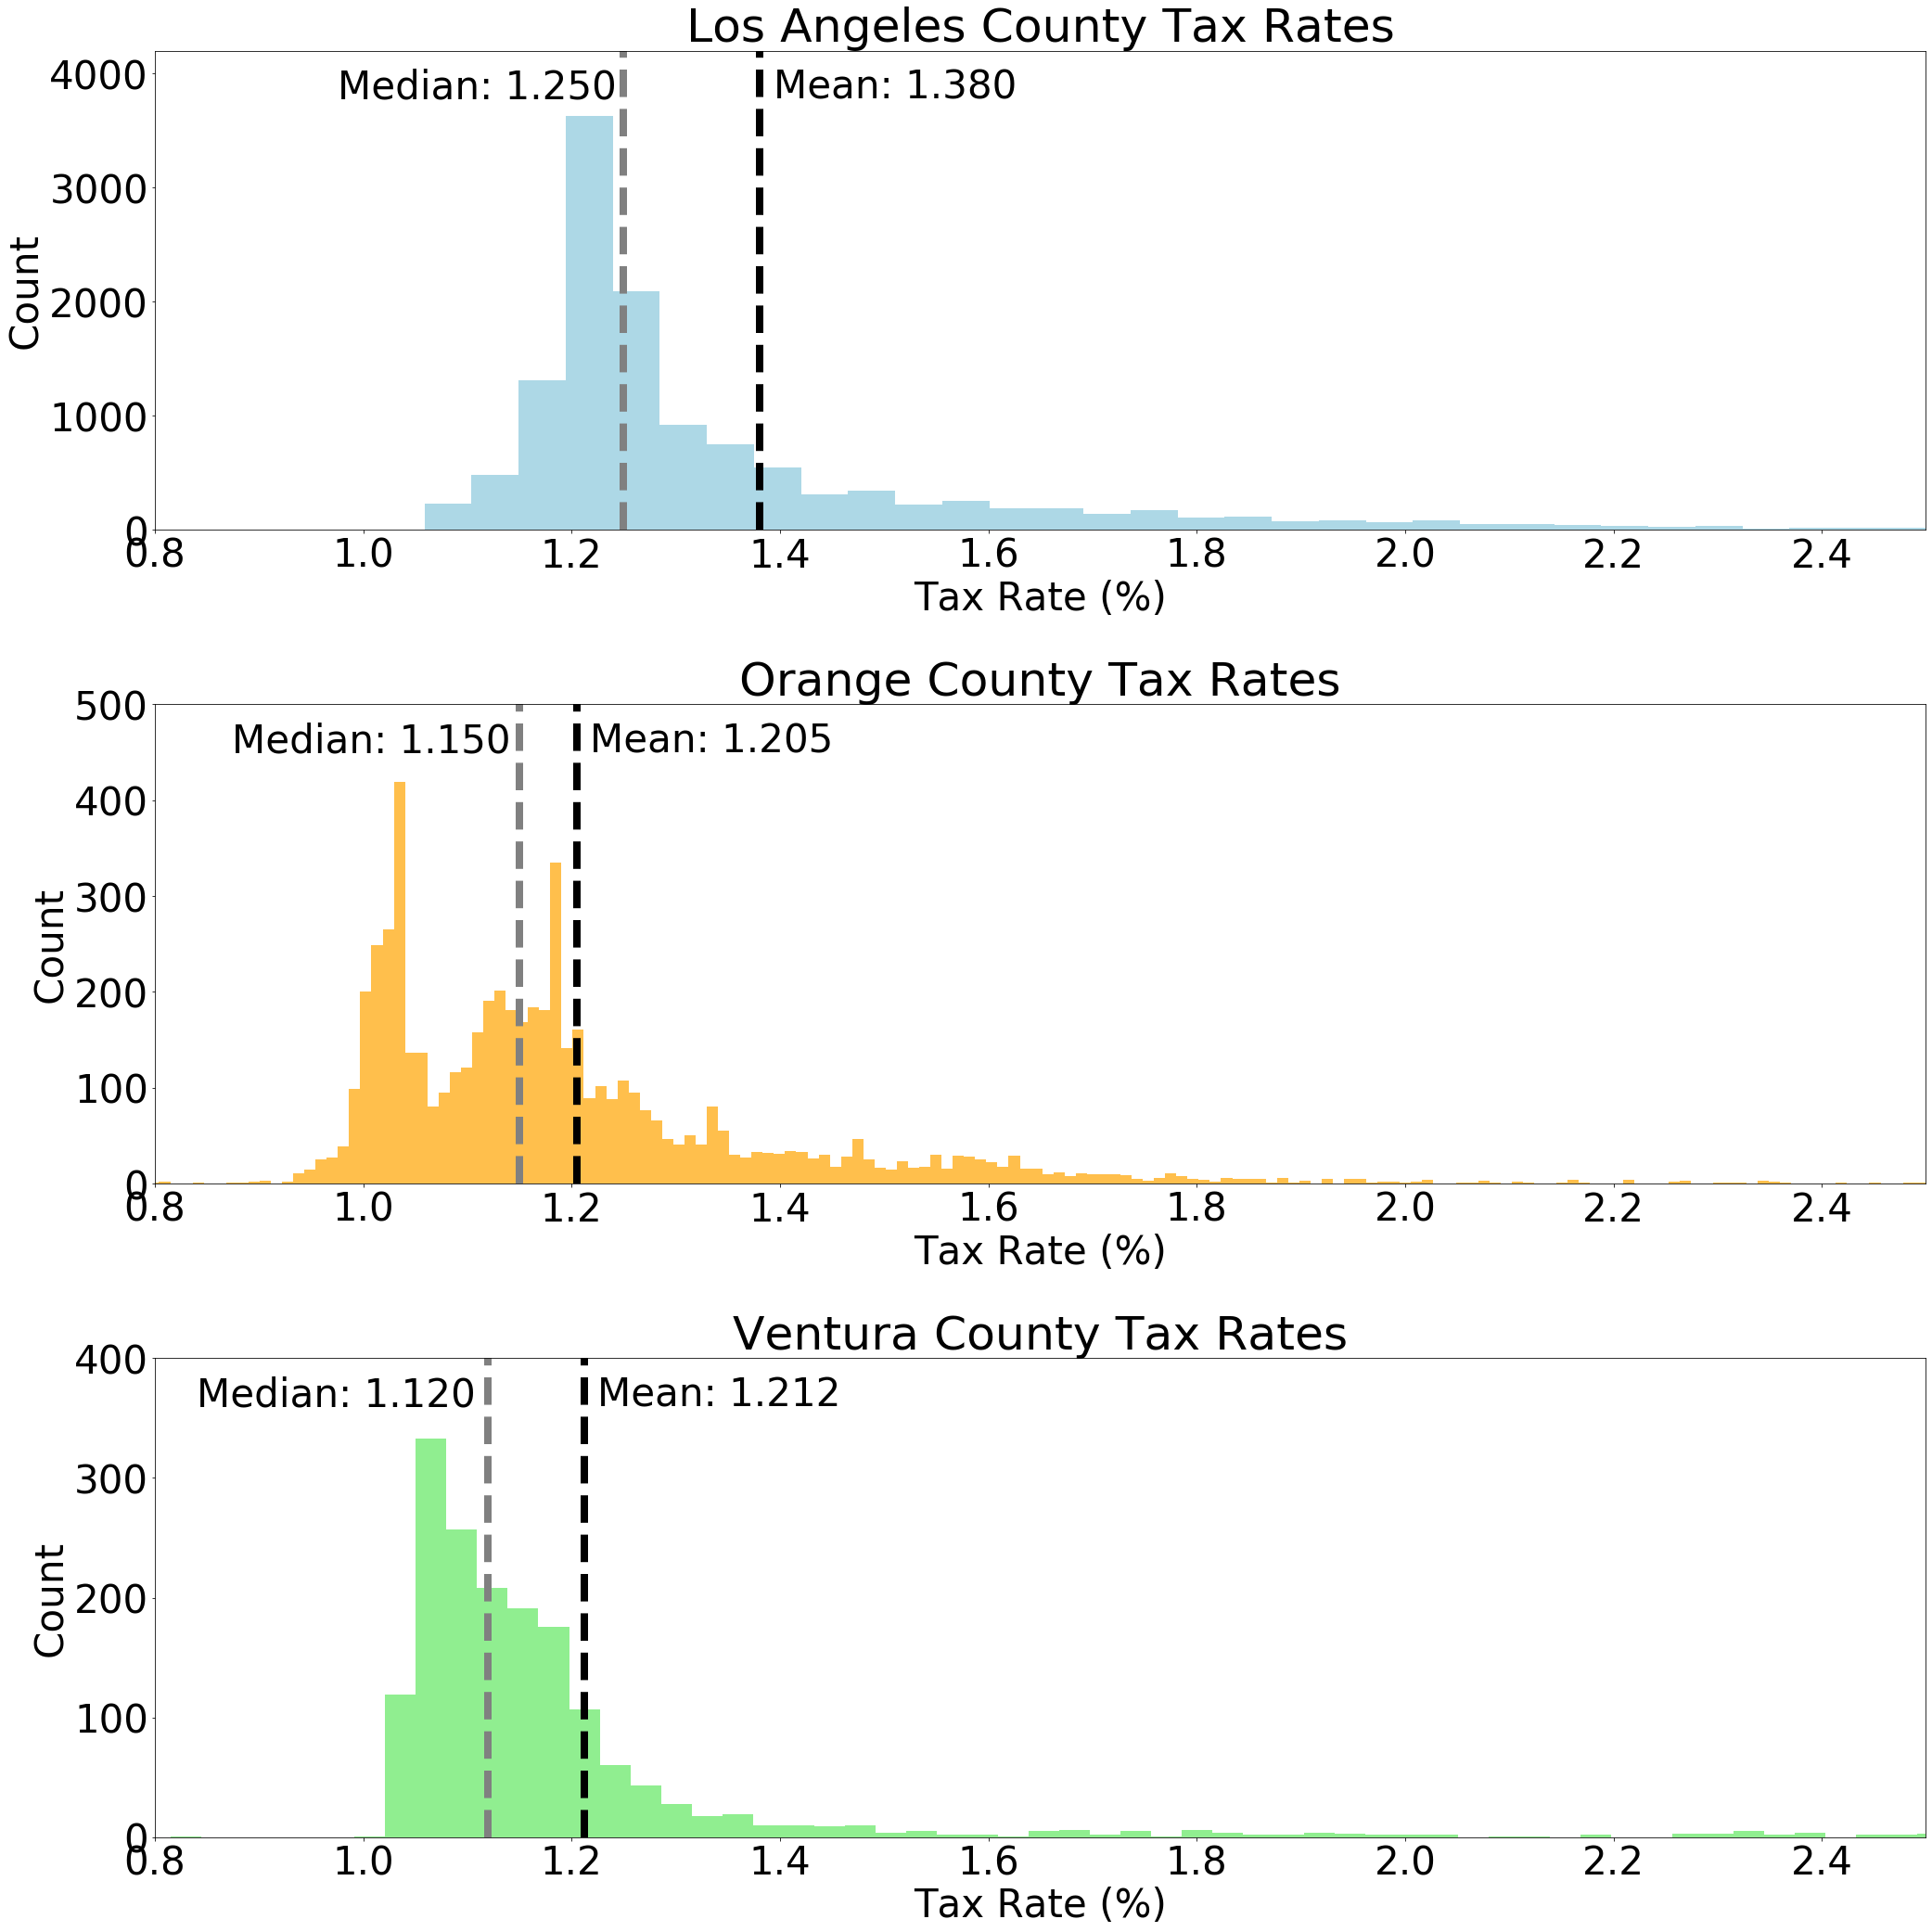

In [17]:
plt.rcParams.update({'font.size': 42}) # Sets global characteristics for font size

plt.figure(figsize=(30,30))
plt.subplot(3,1,1) # 
plt.hist(los_angeles_taxrate, bins = 1000, color = 'lightblue')
plt.xlim(0.8, 2.5) # Cropping range of x-axis
plt.ylim(0, 4200)
plt.title('Los Angeles County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(los_angeles_taxrate.mean(), color='k', linestyle='dashed', linewidth=8) # Creating visualization line for mean tax rate
plt.text(los_angeles_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(los_angeles_taxrate.mean())) # Creating annotation for mean tax rate line
plt.axvline(los_angeles_taxrate.median(), color='gray', linestyle='dashed', linewidth=8) # Creating visualization line for median tax rate
plt.text(los_angeles_taxrate.median()*.78, max_ylim*0.9, 'Median: {:.3f}'.format(los_angeles_taxrate.median())) # Creating annotation for median tax rate line 

plt.subplot(3,1,2)
plt.hist(orange_taxrate, bins = 1000, color = 'orange', alpha = 0.7)
plt.xlim(0.8, 2.5)
plt.ylim(0, 500)
plt.title('Orange County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(orange_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(orange_taxrate.mean()))
plt.axvline(orange_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.median()*.76, max_ylim*0.9, 'Median: {:.3f}'.format(orange_taxrate.median()))

plt.subplot(3,1,3)
plt.hist(ventura_taxrate, bins = 1000, color = 'lightgreen')
plt.xlim(0.8, 2.5)
plt.ylim(0, 400)
plt.title('Ventura County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(ventura_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(ventura_taxrate.mean()))
plt.axvline(ventura_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.median()*.75, max_ylim*0.9, 'Median: {:.3f}'.format(ventura_taxrate.median()))

plt.tight_layout() # Reduces overlap of labels
# Uncomment the line below to save a .png of the visualization
# plt.savefig('county_tax_rates')
plt.show()

### Key Takeaways
- Mean tax rate is about 15% higher in Los Angeles county than in Orange or Venutra counties
- Orange county has the least positive skew, demonstrated by the smallest difference between the median and mean
- Los Angeles county has the most positive skew, demonstrated by the larger difference between the median and mean
- Given the large range of tax rates, most tax rates fall between 1 and 2 percent